In [57]:
import os

import numpy as np
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
predictions_1 = np.load('/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results/univariate_with_embedding/results/informer_sl12_ll6_pl3_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy')
predictions_1.shape

(5746, 3, 1)

In [3]:
predictions_2 = np.load('/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results/univariate_without_embedding/results/informer_sl12_ll6_pl3_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy')
predictions_2.shape

(5746, 3, 1)

In [4]:
predictions_3 = np.load('/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results/univariate_with_embedding_long_range_pred/results/informer_sl48_ll24_pl12_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy')
predictions_3.shape

(5701, 12, 1)

In [5]:
predictions_4 = np.load('/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results/multivariate_with_embedding/results/informer_sl12_ll6_pl3_dm2048_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy')
predictions_4.shape

(5746, 3, 78)

In [6]:
predictions_5 = np.load('/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results/multivariate_without_embedding/results/informer_sl12_ll6_pl3_dm2048_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy')
predictions_5.shape

(5746, 3, 78)

In [7]:
np.min(predictions_3), np.max(predictions_3)

(np.float64(255.61323671184448), np.float64(50701.08060310581))

In [8]:
from src.utils import get_target_microservice_id

get_target_microservice_id()

np.int64(25)

In [44]:
from src.utils import get_test_workloads

def get_pred_and_true_workloads(filepath, take_first=True):
    test_workloads = get_test_workloads()
    target_microservice_id = get_target_microservice_id()
    preds = np.load(filepath)
    pred_len = preds.shape[0] + preds.shape[1] - 1
    selected_test_workloads = test_workloads[-pred_len:]
    
    pred_workloads = np.zeros((pred_len,), dtype=np.float32)
    
    for idx in range(preds.shape[0]):
        pred_group = preds[idx, :, :]
        n_future = pred_group.shape[0]
        pred_n_nodes = pred_group.shape[1]
        
        node_id = 0 if pred_n_nodes == 1 else target_microservice_id
        
        if take_first:
            if idx < preds.shape[0] - 1:
                pred_workloads[idx] = pred_group[0, node_id]
            else:
                pred_workloads[idx:idx + n_future] = pred_group[:, node_id]
        else:
            if idx == 0:
                pred_workloads[idx:idx + n_future] = pred_group[:, node_id]
            else:
                pred_workloads[idx + n_future - 1] = pred_group[-1, node_id]
                
    return pred_workloads, selected_test_workloads

In [88]:
import matplotlib.pyplot as plt

def plot_pred_and_true_workloads(filepath, title, save_filepath, take_first=True):
    pred_workloads, true_workloads = get_pred_and_true_workloads(filepath, take_first)
    
    train_days = int(os.getenv('WORKLOAD_PREDICTION_TRAINING_DAYS'))
    valid_days = int(os.getenv('WORKLOAD_PREDICTION_VALIDATION_DAYS'))
    test_days = int(os.getenv('WORKLOAD_PREDICTION_TEST_DAYS'))
    
    test_workloads = get_test_workloads()
    start_idx, end_idx = len(test_workloads) - len(pred_workloads), len(test_workloads)
    
    x_values = np.arange(0, len(test_workloads))
    x_plot = x_values[start_idx:end_idx]
    
    minutes_per_day = 1440
    days = np.arange(0, test_days + 1)
    day_labels = [str(day + train_days + valid_days) for day in days]
    
    plt.figure(figsize=(14, 7))
    
    plt.plot(x_plot, true_workloads, label='True Workloads', color='red')
    plt.plot(x_plot, pred_workloads, label='Predicted Workloads', color='blue', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('Workload')
    plt.xticks(days * minutes_per_day, day_labels)
    plt.title(title)
    plt.legend()
    plt.savefig(save_filepath)

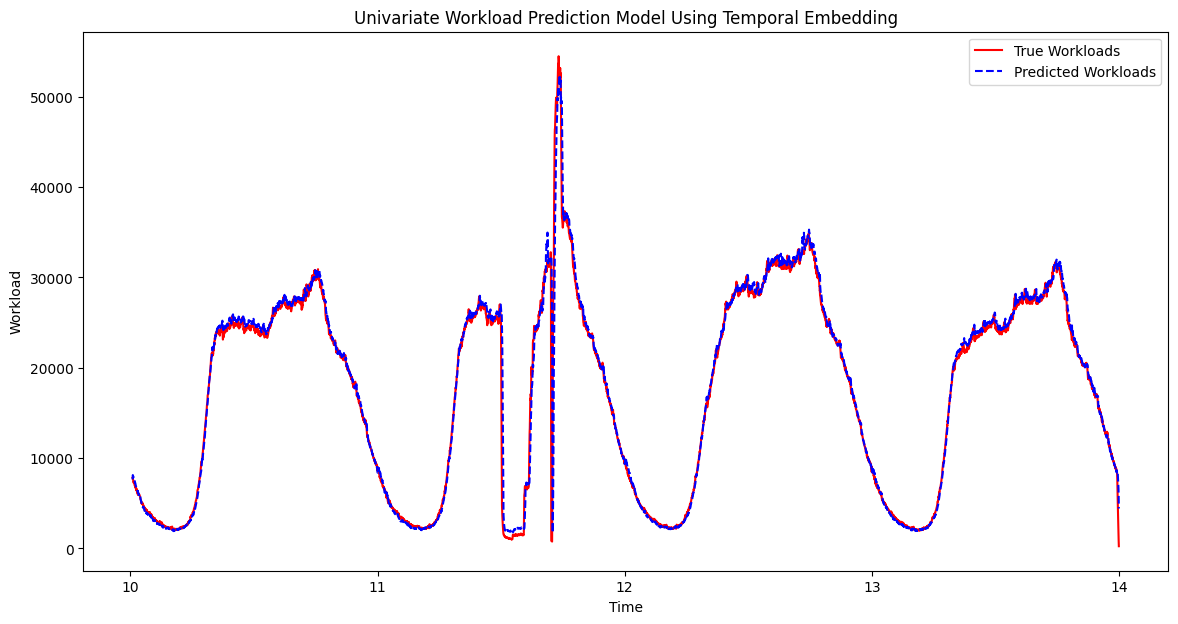

In [96]:
plot_pred_and_true_workloads(
    '/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results/univariate_with_embedding/results/informer_sl12_ll6_pl3_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Model Using Temporal Embedding',
    '../plots/univariate_using_temporal_embedding.png',
    take_first=False
)

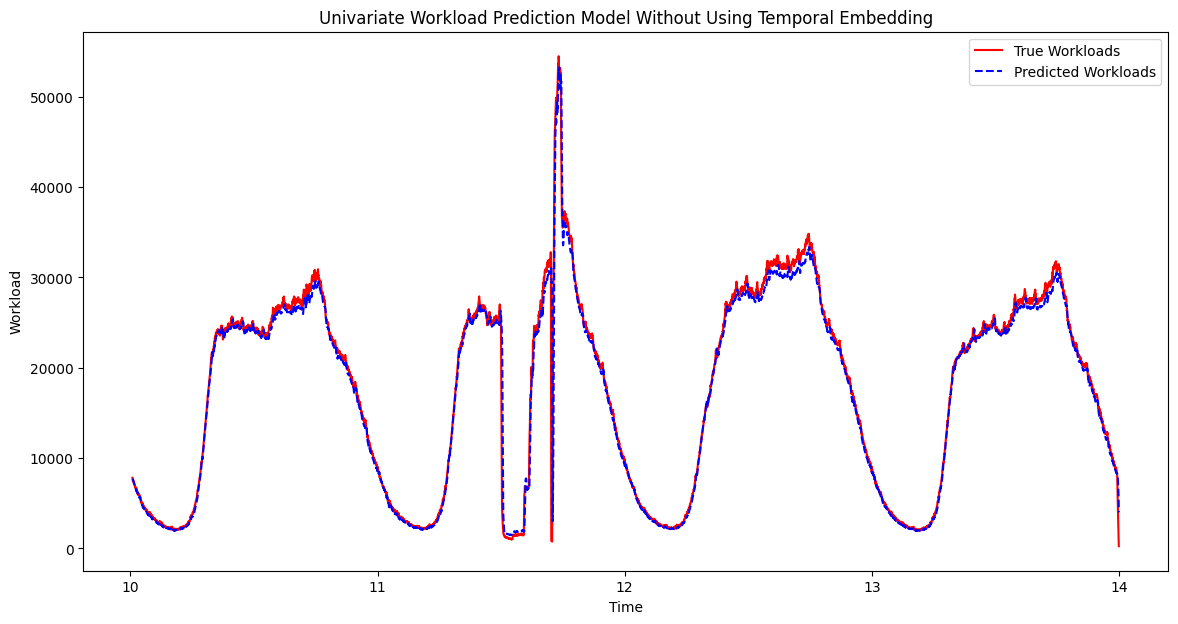

In [97]:
plot_pred_and_true_workloads(
    '/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results/univariate_without_embedding/results/informer_sl12_ll6_pl3_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Model Without Using Temporal Embedding',
    '../plots/univariate_without_using_temporal_embedding.png',
    take_first=False
)

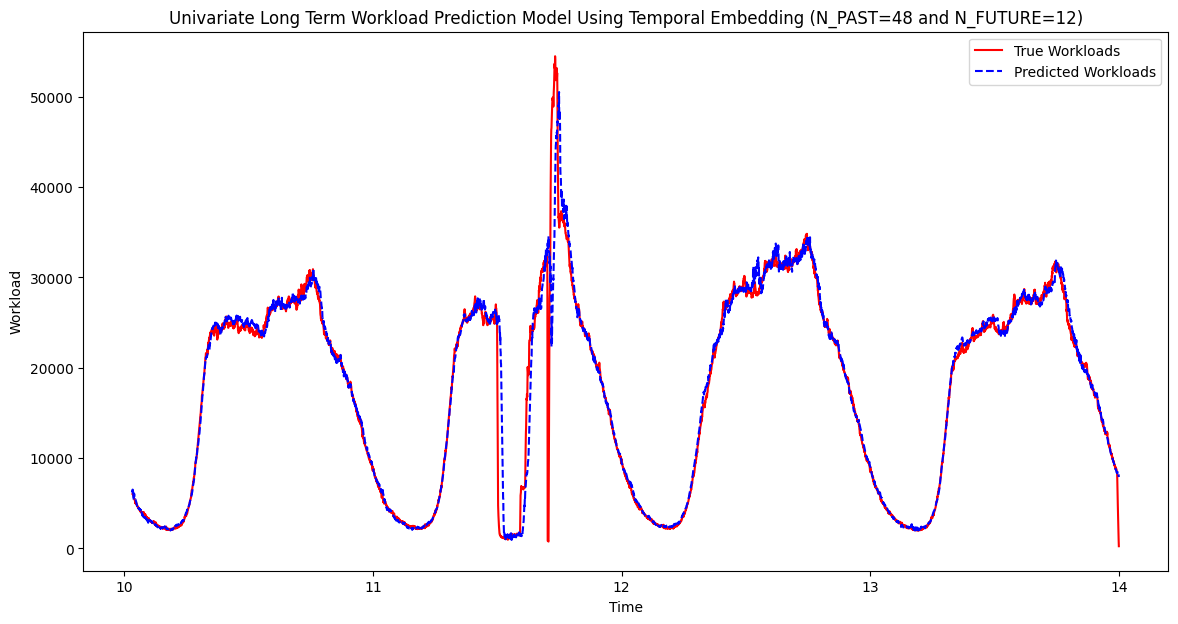

In [95]:
plot_pred_and_true_workloads(
    '/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results/univariate_with_embedding_long_range_pred/results/informer_sl48_ll24_pl12_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Long Term Workload Prediction Model Using Temporal Embedding (N_PAST=48 and N_FUTURE=12)',
    '../plots/univariate_long_term_using_temporal_embedding.png',
    take_first=False
)

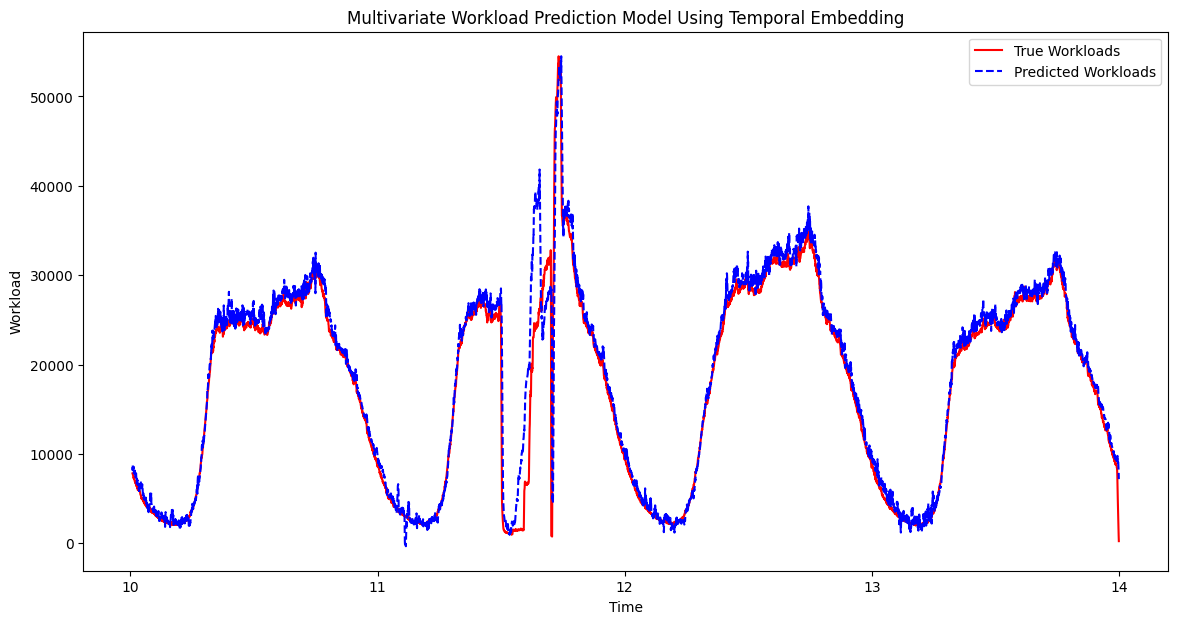

In [98]:
plot_pred_and_true_workloads(
    '/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results/multivariate_with_embedding/results/informer_sl12_ll6_pl3_dm2048_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Multivariate Workload Prediction Model Using Temporal Embedding',
    '../plots/multivariate_using_temporal_embedding.png',
    take_first=False
)

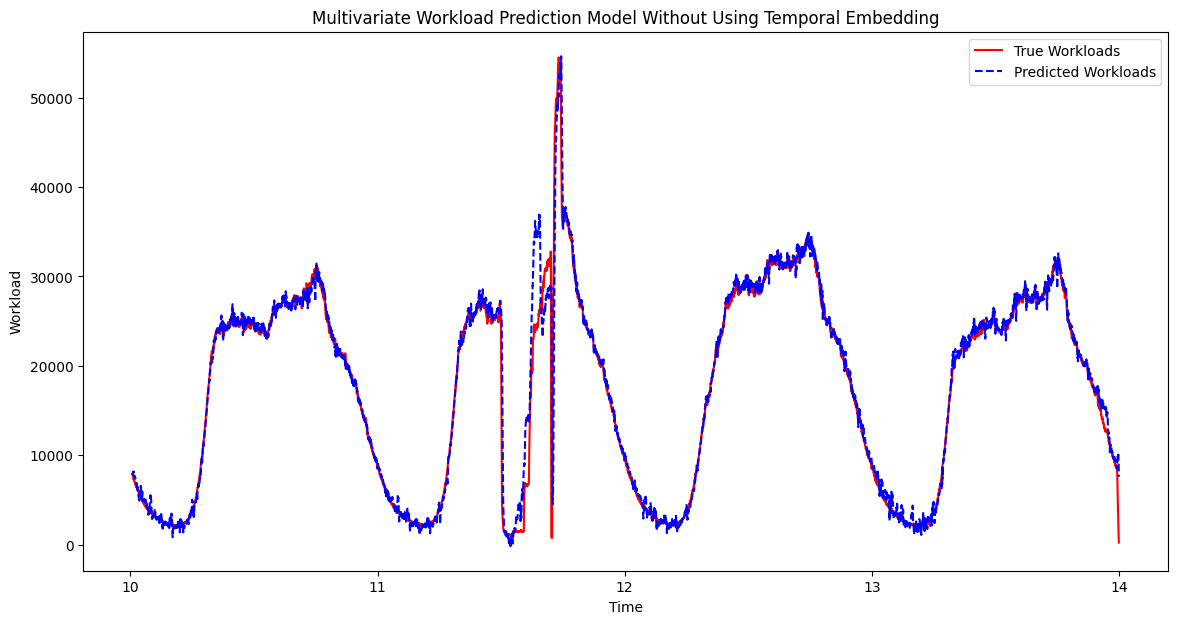

In [99]:
plot_pred_and_true_workloads(
    '/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results/multivariate_without_embedding/results/informer_sl12_ll6_pl3_dm2048_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Multivariate Workload Prediction Model Without Using Temporal Embedding',
    '../plots/multivariate_without_using_temporal_embedding.png',
    take_first=False
)